In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/video-swin-transformer/tensorflow2/swin-small-patch244-window877-kinetics400-1k/1/saved_model.pb
/kaggle/input/video-swin-transformer/tensorflow2/swin-small-patch244-window877-kinetics400-1k/1/keras_metadata.pb
/kaggle/input/video-swin-transformer/tensorflow2/swin-small-patch244-window877-kinetics400-1k/1/variables/variables.index
/kaggle/input/video-swin-transformer/tensorflow2/swin-small-patch244-window877-kinetics400-1k/1/variables/variables.data-00000-of-00001
/kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters/shop_lifter_n_216.mp4
/kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters/shop_lifter_n_98.mp4
/kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters/shop_lifter_n_137.mp4
/kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters/shop_lifter_n_86_1.mp4
/kaggle/input/shoplifting-videos-dataset/Shop DataSet/non shop lifters/shop_lifter_n_19_1.mp4
/kaggle/input/shoplifting-videos-dataset/Shop DataS

In [2]:
!pip install torch torchvision scikit-learn matplotlib -q

In [9]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
from torchvision.models.video import r3d_18

In [10]:
DATA_DIR = "/kaggle/input/shoplifting-videos-dataset/Shop DataSet"
OUTPUT_DIR = "/kaggle/working"
NUM_FRAMES = 16
FRAME_SIZE = 112
TARGET_FPS = 30
BATCH_SIZE = 2
EPOCHS = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
labels, corrupted = [], []

subdirs = [("shop lifters", 1), ("non shop lifters", 0)]
for folder, label in subdirs:
    folder_path = os.path.join(DATA_DIR, folder)
    if not os.path.exists(folder_path):
        continue
    for video_file in os.listdir(folder_path):
        if video_file.lower().endswith((".mp4", ".avi", ".mov", ".mkv")):
            video_path = os.path.join(folder_path, video_file)
            vid = cv2.VideoCapture(video_path)
            if not vid.isOpened():
                corrupted.append(video_path)
            else:
                labels.append([video_path, label])
            vid.release()

df = pd.DataFrame(labels, columns=["video_path", "label"])
df.to_csv(os.path.join(OUTPUT_DIR, "labels.csv"), index=False)
if corrupted:
    print(f"Corrupted videos: {len(corrupted)}")

In [12]:
def check_video_properties(video_path, min_frames=NUM_FRAMES, min_resolution=(FRAME_SIZE, FRAME_SIZE)):
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        return False, None
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    vid.release()
    if frame_count < min_frames or width < min_resolution[0] or height < min_resolution[1]:
        return False, (frame_count, width, height)
    return True, (frame_count, width, height)

df_cleaned = []
for i, row in df.iterrows():
    valid, stats = check_video_properties(row["video_path"])
    if valid:
        df_cleaned.append(row)
df = pd.DataFrame(df_cleaned)
df.to_csv(os.path.join(OUTPUT_DIR, "labels_cleaned.csv"), index=False)
print(f"Videos after resolution/frame check: {len(df)}")

Videos after resolution/frame check: 855


In [14]:
def check_empty_frames(video_path, threshold=10):
    vid = cv2.VideoCapture(video_path)
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    empty_frames = 0
    for i in range(min(100, frame_count)):
        ret, frame = vid.read()
        if ret and np.std(frame) < threshold:
            empty_frames += 1
    vid.release()
    return empty_frames / min(100, frame_count) > 0.5

df_filtered = []
for i, row in df.iterrows():
    if not check_empty_frames(row["video_path"]):
        df_filtered.append(row)
df = pd.DataFrame(df_filtered)
df.to_csv(os.path.join(OUTPUT_DIR, "labels_final.csv"), index=False)
print(f"Videos after removing empty frames: {len(df)}")

KeyboardInterrupt: 

In [15]:
min_count = min(df["label"].value_counts())
df_balanced = pd.concat([
    df[df["label"]==1].sample(min_count, random_state=42),
    df[df["label"]==0].sample(min_count, random_state=42)
])
df_balanced.to_csv(os.path.join(OUTPUT_DIR, "labels_balanced.csv"), index=False)
print(f"Balanced dataset size: {len(df_balanced)}")

Balanced dataset size: 648


In [16]:
class VideoDataset(Dataset):
    def __init__(self, df, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE):
        self.df = df.reset_index(drop=True)
        self.num_frames = num_frames
        self.frame_size = frame_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        video_path = self.df.iloc[idx]["video_path"]
        label = self.df.iloc[idx]["label"]
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total_frames-1, self.num_frames, dtype=int)
        frames = []
        for i in range(total_frames):
            ret, frame = cap.read()
            if i in indices and ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (self.frame_size, self.frame_size))
                frame = torch.tensor(frame).permute(2,0,1)/255.0
                frames.append(frame)
        cap.release()
        while len(frames)<self.num_frames:
            frames.append(frames[-1])
        frames = torch.stack(frames).permute(1,0,2,3)  # C,T,H,W
        return frames.float(), torch.tensor(label)

In [17]:
train_df, val_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced["label"], random_state=42)
train_dataset = VideoDataset(train_df)
val_dataset = VideoDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [19]:
model = r3d_18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/3 - Loss: 0.3538
Epoch 2/3 - Loss: 0.0485
Epoch 3/3 - Loss: 0.0098


In [25]:
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        probs = torch.nn.functional.softmax(logits, dim=1)[:,1]  # prob of class 1
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Confusion matrix with hard predictions
all_preds = (all_probs >= 0.5).astype(int)
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


# Accuracy & F1
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")


Confusion Matrix:
 [[64  1]
 [ 0 65]]
Accuracy: 0.9923, F1-score: 0.9924


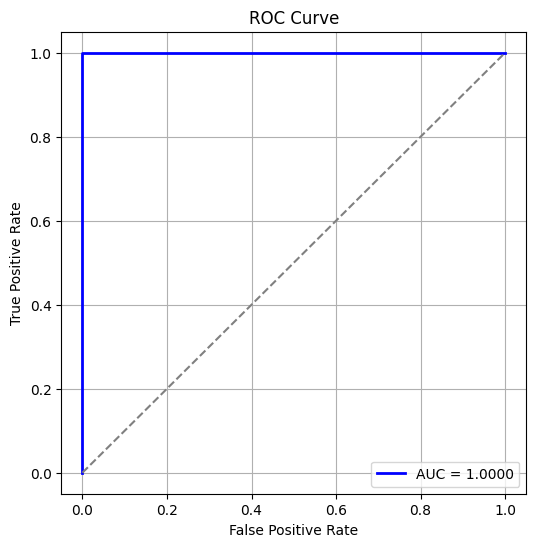

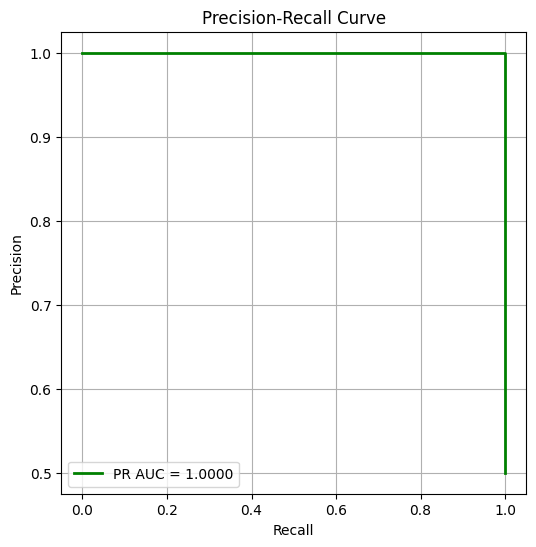

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# all_labels: true labels (numpy array of 0s and 1s)
# all_probs: predicted probabilities for class 1 (floats between 0 and 1)

# -----------------------------
# ROC Curve
# -----------------------------
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Precision-Recall Curve
# -----------------------------
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='green', lw=2, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
